In [1]:
import copy
import math

from PuzzlePiece import *
from SWPuzzleAligner import *
from NWPuzzleAligner import *
from EuclideanSimilarity import *

In [2]:
# gather all the pieces
target_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = PuzzlePiece('3x3_pieces/' + p + '_border.csv', 
                                   border_sampling_rate = .1)

In [3]:
# get the first piece
query = target_pieces.pop('C') # this piece serves as the core

In [9]:
###############################
# REPEAT HERE
##############################
print(target_pieces.keys())

dict_keys(['N', 'NE', 'E', 'SE', 'SW', 'W', 'NW'])


In [10]:
# find the closest match in the other pieces
EucSim = EuclideanSimilarity()
SWAligner = SWPuzzleAligner(EucSim)
NWAligner = NWPuzzleAligner(EucSim)

mx_score = 0
mx_piece = ''

all_align = {}
rough_piece_align = {}
fine_piece_align = {}

rough_alignments_count = 5

min_rough_score = None
min_rough_piece = None
    
for i,p in enumerate(target_pieces):
    
    target = target_pieces[p]
    
    # extend the query to account for circular sequence
    tail_length = min(int(len(target_pieces[p].border_sample) * .25),
                      int(len(query.border_sample) * .25))

    query.extend_border_sample(tail_length)
    target.extend_border_sample(tail_length, reverse = True)
    
    # do a rough alignment with the extended border sample
    rough_piece_align = SWAligner.Align(Q = query.border_sample_ext, 
                                        T = target.border_sample_ext,
                                        window = 5, cutoff_percentile = 0.05,
                                        return_top = rough_alignments_count) 
    
    if max(rough_piece_align['mx']) > mx_score:
        mx_score = max(rough_piece_align['mx'])
        mx_piece = p
    
    all_align[p] = rough_piece_align
    all_align[p]['fine_dist'] = {}
    
    # for each rough alignent, do a fine alignment
    for i in range(rough_alignments_count):
        
        ####################
        # find start and stop matched points for the fine alignment
        
        q_stop = query.ext_to_old_index[rough_piece_align['mx_Q'][i]] + 1
        q_start = q_stop - rough_piece_align['length'][i] - 2
        
        if q_start < 0:
            q_start += len(query.border_sample)
        elif q_start >= len(query.border_sample):
            q_start -= len(query.border_sample)
            
        q_orig_start = query.border_sample[q_start]['orig_idx']
        q_orig_stop = query.border_sample[q_stop]['orig_idx']
        
        if q_orig_start < q_orig_stop:
            q_fine_seq = {i:query.ordered_border[b] 
                          for i,b in enumerate(range(q_orig_start, q_orig_stop,))}
        else:
            idx = [i for i in range(q_orig_start,len(query.ordered_border))]
            idx = idx + [i for i in range(0, q_orig_stop+1)]
            q_fine_seq = {i:query.ordered_border[b] for i,b in enumerate(idx)}
            
        t_start = target.ext_to_old_index[rough_piece_align['mx_T'][i]]
        t_stop = t_start + rough_piece_align['length'][i]
        
        if t_stop >= len(target.border_sample):
            t_stop -= len(target.border_sample)
            
        t_orig_start = target.border_sample[t_start]['orig_idx']
        t_orig_stop = target.border_sample[t_stop]['orig_idx']
        
        if t_orig_start < t_orig_stop:
            t_fine_seq = {i:target.ordered_border[b] for i,b in enumerate(range(t_orig_stop, t_orig_start, -1))}
        else:
            idx = [i for i in range(t_orig_stop,-1,-1)]
            idx = idx + [i for i in range(len(target.ordered_border)-1, t_orig_start-1, -1)]
            t_fine_seq = {i:target.ordered_border[b] for i,b in enumerate(idx)}
        
        min_dist = None
        slip = query.border_sample[1]['orig_idx'] - query.border_sample[0]['orig_idx']
        all_align[p]['fine_dist'][p+str(i)] = {}
        for s in range(2 * slip + 1):
            if s < slip:
                q_slip = { k:q_fine_seq[k] for k in 
                          list(q_fine_seq.keys())[slip+slip-s:len(q_fine_seq)-s] }
            elif s == slip:
                q_slip = { k:q_fine_seq[k] for k in 
                          list(q_fine_seq.keys())[slip:len(q_fine_seq)-slip] }
            else:
                q_slip = { k:q_fine_seq[k] for k in 
                          list(q_fine_seq.keys())[slip+slip-s:len(q_fine_seq)-s]}
            
            fine_dist = EucSim.ComputeSubseqDist(q_slip, t_fine_seq)
            if min_dist is None or fine_dist < min_dist:
                min_dist = fine_dist
                min_slip = s
                
            if min_rough_score is None or min_dist < min_rough_score:
                min_rough_score = min_dist
                min_rough_piece = p
                min_rough_align = i
            
        all_align[p]['fine_dist'][p+str(i)]['fine_dist'] = min_dist
        all_align[p]['fine_dist'][p+str(i)]['fine_slip'] = min_slip
        all_align['best_piece'] = min_rough_piece
        all_align['best_align'] = min_rough_align
            
print(min_rough_piece, min_rough_align, min_rough_score)            
#target = target_pieces.pop(mx_piece)['rough']
target = target_pieces[min_rough_piece]


N 3 0.0


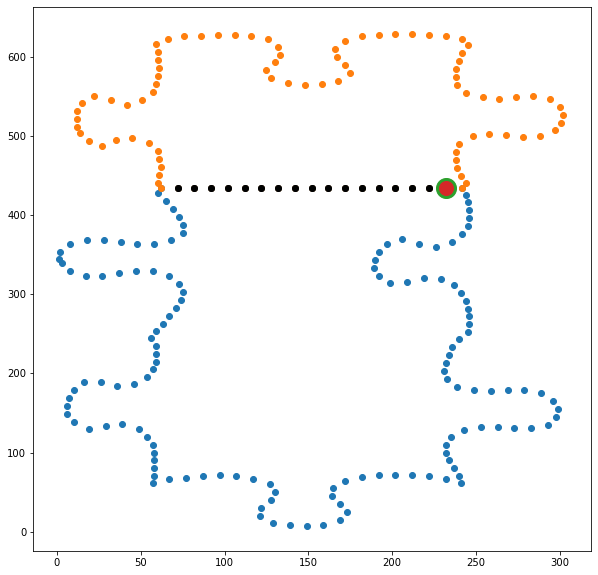

180 152


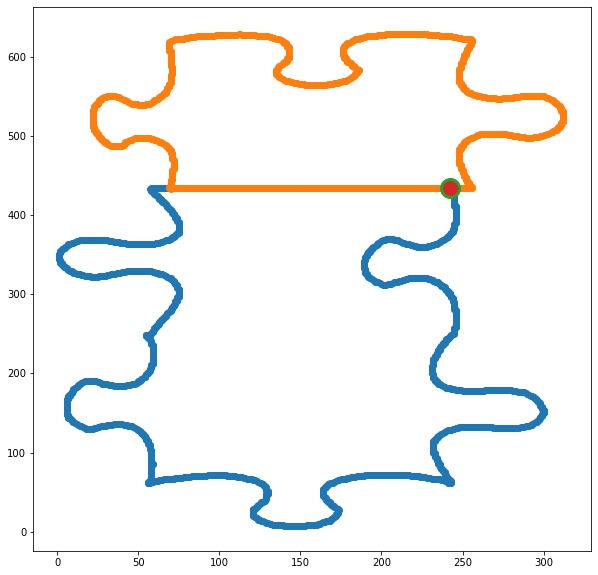

In [11]:
mx_piece = all_align['best_piece']
mx_align = all_align['best_align']
mx_piece_align = mx_piece+str(mx_align)

#plot the current rough alignment
mx = all_align[mx_piece]['mx'][mx_align]
mx_Q = all_align[mx_piece]['mx_Q'][mx_align]
mx_T = all_align[mx_piece]['mx_T'][mx_align]
length = all_align[mx_piece]['length'][mx_align]
min_slip = all_align[mx_piece]['fine_dist'][mx_piece_align]['fine_slip']

# find the aligned points window
Q_pt = query.border_sample[query.ext_to_old_index[mx_Q]]
T_pt = target.border_sample[target.ext_to_old_index[mx_T]] 

# find x,y shift to align pieces based on that one point
T_xshift = T_pt['x'] - Q_pt['x']
T_yshift = T_pt['y'] - Q_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.border_sample[k]['x'] for k,v in query.border_sample.items() ],
             [query.border_sample[k]['y'] for k,v in query.border_sample.items() ])
plt.scatter( [target.border_sample[k]['x'] - T_xshift for k,v in target.border_sample.items() ],
             [target.border_sample[k]['y'] - T_yshift for k,v in target.border_sample.items() ])

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

# show similarity window
# the black and grey points represent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [query.border_sample[query.ext_to_old_index[q]] for q in range(mx_Q - length, mx_Q)]
plt.scatter( [p['x'] for p in Q_window],
             [p['y'] for p in Q_window], c = 'grey' )

T_window = [target.border_sample[target.ext_to_old_index[t]] for t in range(mx_T - length, mx_T)]
plt.scatter( [p['x'] - T_xshift for p in T_window],
             [p['y'] - T_yshift for p in T_window], c = 'black' )
plt.show()

# find the fine aligned points window
q_stop = query.ext_to_old_index[mx_Q] + 1
q_start = q_stop - length - 2

if q_start < 0:
    q_start += len(query.border_sample)
elif q_start >= len(query.border_sample):
    q_start -= len(query.border_sample)

q_orig_start = query.border_sample[q_start]['orig_idx']
q_orig_stop = query.border_sample[q_stop]['orig_idx']

if q_orig_start < q_orig_stop:
    q_fine_seq = {i:query.ordered_border[b] 
                  for i,b in enumerate(range(q_orig_start, q_orig_stop,))}
else:
    idx = [i for i in range(q_orig_start,len(query.ordered_border))]
    idx = idx + [i for i in range(0, q_orig_stop+1)]
    q_fine_seq = {i:query.ordered_border[b] for i,b in enumerate(idx)}

t_start = target.ext_to_old_index[mx_T]
t_stop = t_start + length

if t_stop >= len(target.border_sample):
    t_stop -= len(target.border_sample)

t_orig_start = target.border_sample[t_start]['orig_idx']
t_orig_stop = target.border_sample[t_stop]['orig_idx']

Q_pt_fine = query.ordered_border[q_orig_stop - min_slip]
T_pt_fine = target.ordered_border[t_orig_start]

 # find x,y shift to align pieces based on that one point
T_xshift = T_pt_fine['x'] - Q_pt_fine['x']
T_yshift = T_pt_fine['y'] - Q_pt_fine['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.ordered_border[k]['x'] for k,v in query.ordered_border.items() ],
             [query.ordered_border[k]['y'] for k,v in query.ordered_border.items() ])
plt.scatter( [target.ordered_border[k]['x'] - T_xshift for k,v in target.ordered_border.items() ],
             [target.ordered_border[k]['y'] - T_yshift for k,v in target.ordered_border.items() ])

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt_fine['x'], Q_pt_fine['y'], s=400)
plt.scatter( T_pt_fine['x'] - T_xshift, T_pt_fine['y'] - T_yshift, s=196 ) 

print(len(q_fine_seq), len(t_fine_seq))

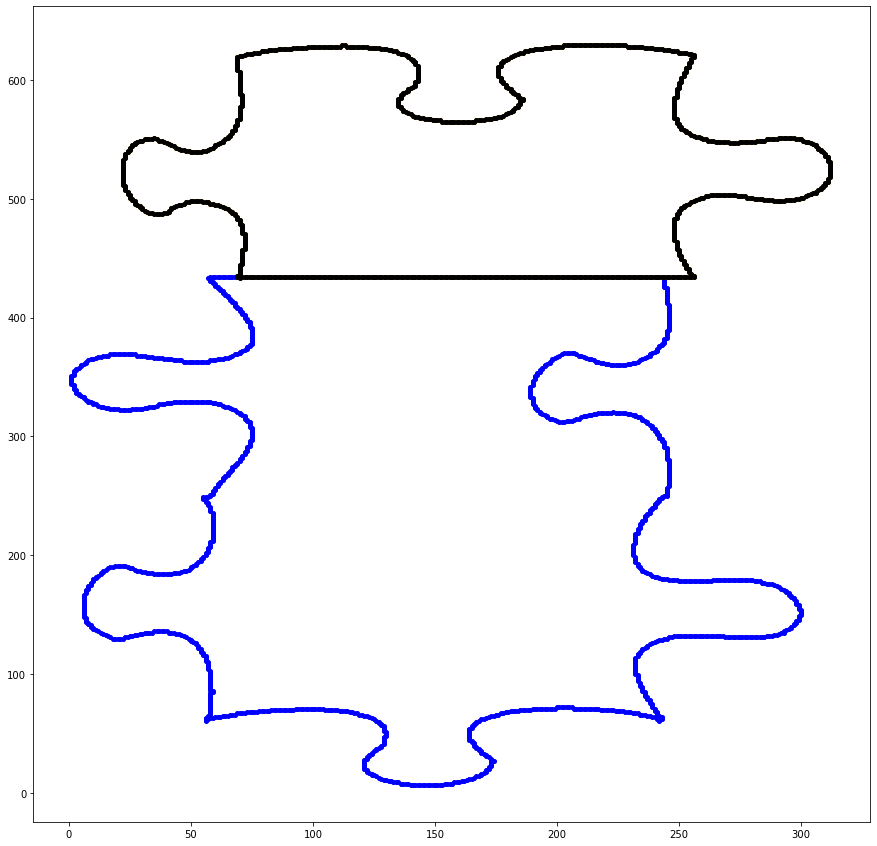

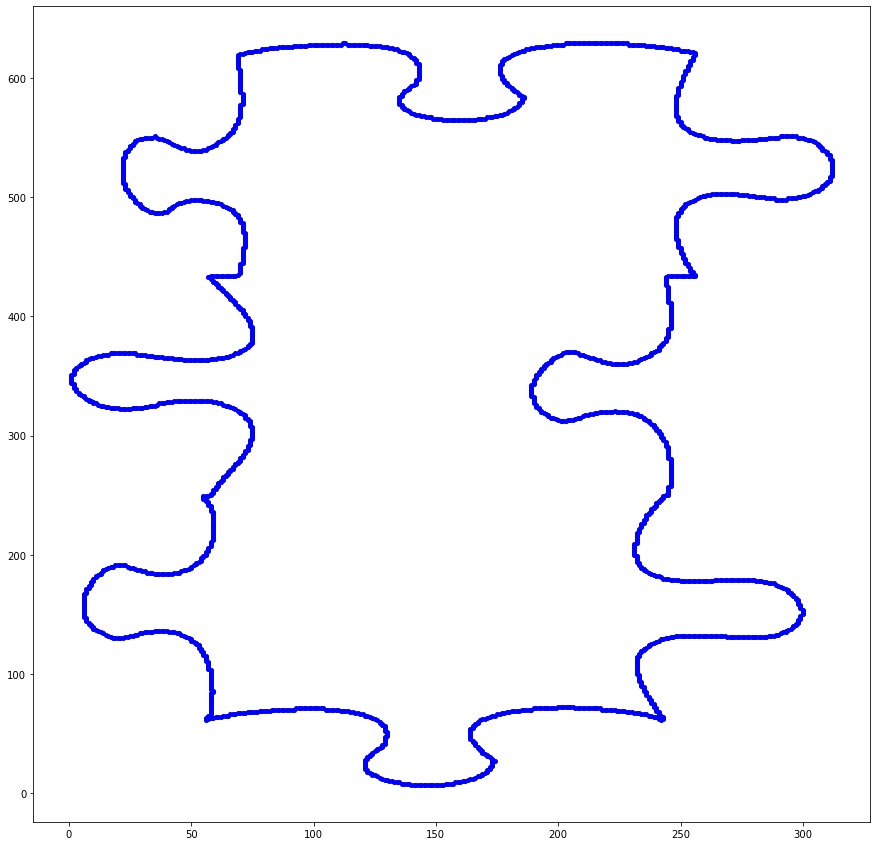

In [12]:
## t_start = target.ext_to_old_index[mx_T]
t_stop = t_start + length

if t_stop >= len(target.border_sample):
    t_stop -= len(target.border_sample)

t_orig_start = target.border_sample[t_start]['orig_idx']
t_orig_stop = target.border_sample[t_stop]['orig_idx']

if t_orig_start < t_orig_stop:
    t_fine_seq = {i:target.ordered_border[b] for i,b in enumerate(range(t_orig_stop, t_orig_start, -1))}
else:
    idx = [i for i in range(t_orig_stop,-1,-1)]
    idx = idx + [i for i in range(len(target.ordered_border)-1, t_orig_start-1, -1)]
    t_fine_seq = {i:target.ordered_border[b] for i,b in enumerate(idx)}
    
q_stop = query.ext_to_old_index[mx_Q] + 1
q_start = q_stop - length - 2

if q_start < 0:
    q_start += len(query.border_sample)
elif q_start >= len(query.border_sample):
    q_start -= len(query.border_sample)

q_orig_stop = query.border_sample[q_stop]['orig_idx'] - min_slip
q_orig_start = q_orig_stop - len(t_fine_seq)

if q_orig_start < q_orig_stop:
    q_fine_seq = {i:query.ordered_border[b] 
                  for i,b in enumerate(range(q_orig_start, q_orig_stop,))}
else:
    idx = [i for i in range(q_orig_start,len(query.ordered_border))]
    idx = idx + [i for i in range(0, q_orig_stop+1)]
    q_fine_seq = {i:query.ordered_border[b] for i,b in enumerate(idx)}

target.reposition_by_border(t_fine_seq, q_fine_seq)   
    
    
Q_x = [ q[1]['x'] for q in query.ordered_border.items() ]
Q_y = [ q[1]['y'] for q in query.ordered_border.items() ]

T_orig_x = [ t[1]['x'] for t in target.border.items() ]
T_orig_y = [ t[1]['y'] for t in target.border.items() ]

T_shifted_x = [t[1]['x'] for t in target.border.items() ]
T_shifted_y = [t[1]['y'] for t in target.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_x, Q_y, c = 'blue', s=16)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=16)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=16)
            
query.merge(target)

Q_merged_x = [ q[1]['x'] for q in query.border.items() ]
Q_merged_y = [ q[1]['y'] for q in query.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_merged_x, Q_merged_y, c = 'blue', s=16)

In [8]:
#########################
# REPEAT ABOVE
######################### 

# burn this one for now
target = target_pieces.pop(mx_piece)